## 📚 1. Importing Libraries

In [2]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123
# Load the necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.preprocessing import image as keras_image
from scikeras.wrappers import KerasClassifier

## 📁 2. Dataset Preparation
We gather the image file paths and corresponding labels from the directory structure.

In [3]:
import os
import pandas as pd

# Define the directory containing the training data
train_data_dir = 'Training/'

# Initialize lists to store file paths and labels
filepaths = []
labels = []

# Iterate over each folder in the directory
for folder in os.listdir(train_data_dir):
    folder_path = os.path.join(train_data_dir, folder)
    # Check if it's a directory
    if os.path.isdir(folder_path):
        # List all files in this directory
        files = os.listdir(folder_path)
        for file in files:
            file_path = os.path.join(folder_path, file)
            # Append the file path and label
            filepaths.append(file_path)
            labels.append(folder)

# Create a DataFrame with file paths and labels
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis=1)

# Display the DataFrame
print(train_df)

# You can also display the total number of images and images per class:
print("Total images:", len(train_df))
print("Images per class:", train_df['labels'].value_counts())


                               filepaths      labels
0        Training/notumor/Tr-no_0118.jpg     notumor
1        Training/notumor/Tr-no_0406.jpg     notumor
2        Training/notumor/Tr-no_0158.jpg     notumor
3        Training/notumor/Tr-no_1110.jpg     notumor
4        Training/notumor/Tr-no_0742.jpg     notumor
...                                  ...         ...
5707  Training/meningioma/Tr-me_0043.jpg  meningioma
5708  Training/meningioma/Tr-me_0275.jpg  meningioma
5709  Training/meningioma/Tr-me_0816.jpg  meningioma
5710  Training/meningioma/Tr-me_0403.jpg  meningioma
5711  Training/meningioma/Tr-me_1311.jpg  meningioma

[5712 rows x 2 columns]
Total images: 5712
Images per class: labels
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64


In [4]:
train_df

,filepaths,labels
0,Training/notumor/Tr-no_0118.jpg,notumor
1,Training/notumor/Tr-no_0406.jpg,notumor
2,Training/notumor/Tr-no_0158.jpg,notumor
3,Training/notumor/Tr-no_1110.jpg,notumor
4,Training/notumor/Tr-no_0742.jpg,notumor
...,...,...
5707,Training/meningioma/Tr-me_0043.jpg,meningioma
5708,Training/meningioma/Tr-me_0275.jpg,meningioma
5709,Training/meningioma/Tr-me_0816.jpg,meningioma
5710,Training/meningioma/Tr-me_0403.jpg,meningioma


In [78]:
# Generate data paths with labels
train_data_dir = 'Training//'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

## 🧹 3. Data Preprocessing
This section handles label encoding and visual exploration of the data.

In [23]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [24]:
IMG_SIZE = (224,224)

In [37]:
def preprocess_image(input_path, output_path, save_format=None):
    img = Image.open(input_path)
    img = np.array(img)  # Convert PIL Image to numpy array for OpenCV processing

    # Ensure the image is in RGB format if it's a PNG with an alpha channel
    if img.shape[-1] == 4:  # Image has 4 channels
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)

    img = cv2.resize(img, dsize=IMG_SIZE, interpolation=cv2.INTER_CUBIC)
    
    # Check if the image is already in grayscale; only convert if it's in color
    if len(img.shape) == 3 and img.shape[2] == 3:  # Check for 3 channels
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img  # It's already a single channel image

    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Assuming you want to process and save the contour image; otherwise, adjust accordingly
    img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)
    img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
    img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
    img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
    img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

    ADD_PIXELS = 0
    new_img = img_pnt[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    
    if save_format:
        output_path = os.path.splitext(output_path)[0] + '_filtered.' + save_format
    cv2.imwrite(output_path, new_img)  # Save the processed image


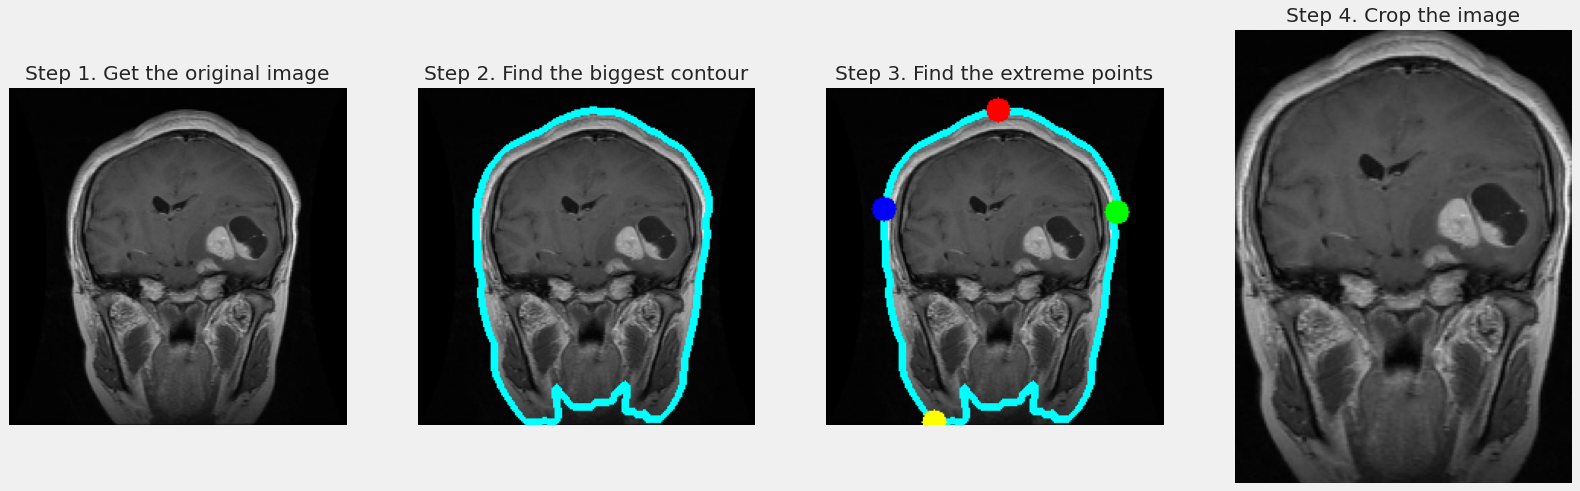

In [62]:
plt.figure(figsize=(25,25))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [79]:
train_df

,filepaths,labels
0,Training//notumor/Tr-no_0118.jpg,notumor
1,Training//notumor/Tr-no_0406.jpg,notumor
2,Training//notumor/Tr-no_0158.jpg,notumor
3,Training//notumor/Tr-no_1110.jpg,notumor
4,Training//notumor/Tr-no_0742.jpg,notumor
...,...,...
5707,Training//meningioma/Tr-me_0043.jpg,meningioma
5708,Training//meningioma/Tr-me_0275.jpg,meningioma
5709,Training//meningioma/Tr-me_0816.jpg,meningioma
5710,Training//meningioma/Tr-me_0403.jpg,meningioma


In [52]:
source_dir = 'Testing'
destination_dir = 'Testing_2'

# Create new directories and preprocess images
for category in os.listdir(source_dir):
    category_path = os.path.join(source_dir, category)
    new_category_path = os.path.join(destination_dir, category.replace(" ", "_"))  # Replace spaces with underscores for folder names
    os.makedirs(new_category_path, exist_ok=True)
    
    for image_name in os.listdir(category_path):
        input_path = os.path.join(category_path, image_name)
        output_path = os.path.join(new_category_path, image_name)
        
        # Apply preprocessing with the modified function
        preprocess_image(input_path, 
            output_path, save_format='png')

print("Preprocessing complete.")


Preprocessing complete.


In [81]:
# Generate data paths with labels
test_data_dir = 'Testing/'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis= 1)

In [82]:
ts_df

,filepaths,labels
0,Testing/notumor/Te-no_0302.jpg,notumor
1,Testing/notumor/Te-no_0264.jpg,notumor
2,Testing/notumor/Te-no_0061.jpg,notumor
3,Testing/notumor/Te-no_0051.jpg,notumor
4,Testing/notumor/Te-no_0050.jpg,notumor
...,...,...
1306,Testing/meningioma/Te-me_0133.jpg,meningioma
1307,Testing/meningioma/Te-me_0094.jpg,meningioma
1308,Testing/meningioma/Te-me_0158.jpg,meningioma
1309,Testing/meningioma/Te-me_0015.jpg,meningioma


In [83]:
valid_df, test_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [84]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


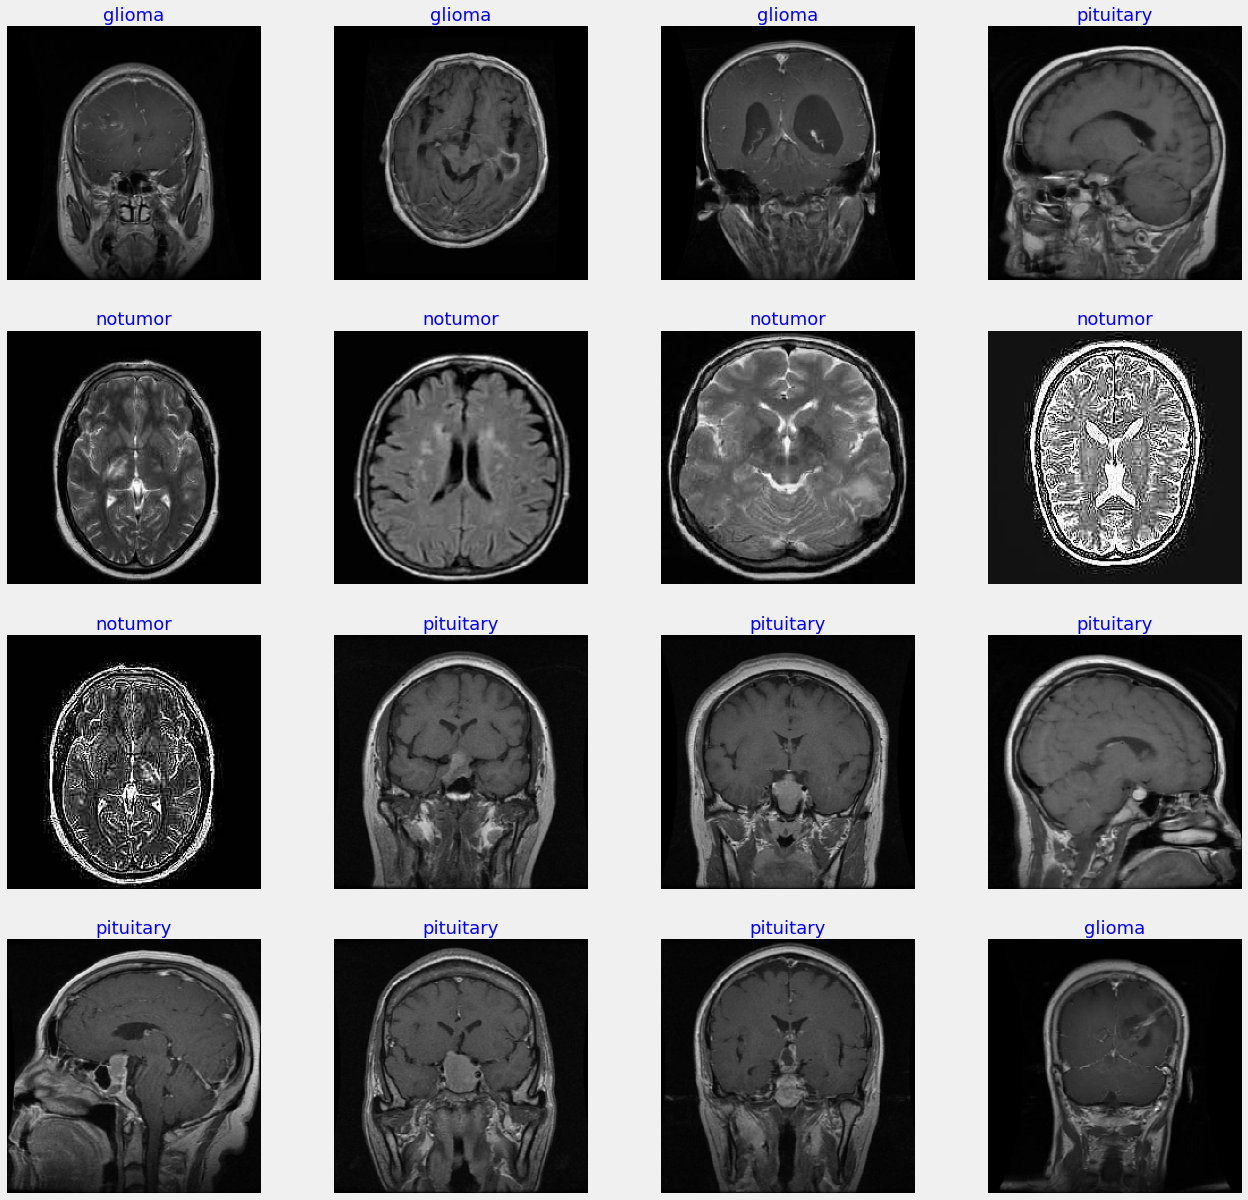

In [86]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 18)
    plt.axis('off')
plt.savefig('sample_training.png')
plt.show()

## 🧠 3. Model Building
We will build a convolutional neural network (CNN) using the MobileNetV2 architecture as a feature extractor.

In [69]:
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Reshape, Dense, multiply, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax

class SqueezeExciteBlock(Layer):
    def __init__(self, input_channels, ratio=16, **kwargs):
        super(SqueezeExciteBlock, self).__init__(**kwargs)
        self.input_channels = input_channels
        self.ratio = ratio

    def build(self, input_shape):
        self.se = Sequential([
            GlobalAveragePooling2D(),
            Dense(self.input_channels // self.ratio, activation='relu', use_bias=False),
            Dense(self.input_channels, activation='sigmoid', use_bias=False),
            Reshape((1, 1, self.input_channels))
        ])

    def call(self, inputs, **kwargs):
        x = self.se(inputs)
        return multiply([inputs, x])

    def get_config(self):
        config = super(SqueezeExciteBlock, self).get_config()
        config.update({
            'input_channels': self.input_channels,
            'ratio': self.ratio
        })
        return config

# Define the model
img_shape = (224, 224, 3)
class_count = 4

model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=img_shape),
    Conv2D(64, (3, 3), activation='relu'),
    SqueezeExciteBlock(64),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    SqueezeExciteBlock(128),
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    SqueezeExciteBlock(256),
    MaxPooling2D((2, 2)),
    
    Conv2D(512, (3, 3), activation='relu'),
    Conv2D(512, (3, 3), activation='relu'),
    Conv2D(512, (3, 3), activation='relu'),
    SqueezeExciteBlock(512),
    MaxPooling2D((2, 2)),
    
    Conv2D(512, (3, 3), activation='relu'),
    Conv2D(512, (3, 3), activation='relu'),
    Conv2D(512, (3, 3), activation='relu'),
    SqueezeExciteBlock(512),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(class_count, activation='softmax')
])

model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 conv2d_66 (Conv2D)          (None, 220, 220, 64)      36928     
                                                                 
 squeeze_excite_block_5 (Squ  (None, 220, 220, 64)     512       
 eezeExciteBlock)                                                
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 108, 108, 128)     73856     
                                                                 
 conv2d_68 (Conv2D)          (None, 106, 106, 128)    

In [ ]:
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 47, 47, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 21, 21, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 19, 19, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 17, 17, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

## 🏋️ 4. Model Training And Evaluation
We will now train the CNN model on the MRI image dataset.

In [70]:
epochs = 40   # number of all epochs in training

history = model.fit(train_gen , epochs= epochs , verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/40
357/357 [==============================] - 55s 144ms/step - loss: 1.1284 - accuracy: 0.4755 - val_loss: 1.3800 - val_accuracy: 0.4214
Epoch 2/40
357/357 [==============================] - 51s 144ms/step - loss: 0.9122 - accuracy: 0.6028 - val_loss: 0.9438 - val_accuracy: 0.5893
Epoch 3/40
357/357 [==============================] - 52s 144ms/step - loss: 0.7353 - accuracy: 0.7022 - val_loss: 0.9990 - val_accuracy: 0.5847
Epoch 4/40
357/357 [==============================] - 52s 144ms/step - loss: 0.6228 - accuracy: 0.7519 - val_loss: 0.7491 - val_accuracy: 0.6885
Epoch 5/40
357/357 [==============================] - 51s 144ms/step - loss: 0.5492 - accuracy: 0.7855 - val_loss: 0.6857 - val_accuracy: 0.7191
Epoch 6/40
357/357 [==============================] - 52s 144ms/step - loss: 0.4973 - accuracy: 0.8009 - val_loss: 0.6425 - val_accuracy: 0.7130
Epoch 7/40
357/357 [==============================] - 53s 149ms/step - loss: 0.4260 - accuracy: 0.8349 - val_loss: 0.6166 - val_ac

In [58]:

# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = 4
model =Sequential ([
    Conv2D(filters=64,kernel_size=(3,3),activation="relu",input_shape=img_shape),
    Conv2D(filters=64,kernel_size=(3,3),activation="relu"),
    MaxPooling2D((2,2)),
    
    Conv2D(filters=128,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=128,kernel_size=(3,3),activation="relu"),
    MaxPooling2D((2,2)),
    
    
    Conv2D(filters=256,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=256,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=256,kernel_size=(3,3),activation="relu"),
    MaxPooling2D((2,2)),
    
    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    MaxPooling2D((2,2)),
    
    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(256,activation="relu"),
    
    Dense(128,activation="relu"),
    Dense(4,activation="softmax")
])
model.compile (Adamax(learning_rate=0.001),loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()
epochs = 10   # number of all epochs in training

history = model.fit(train_gen , epochs= epochs , verbose= 1, validation_data= valid_gen, shuffle= False)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 conv2d_27 (Conv2D)          (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 108, 108, 128)     73856     
                                                                 
 conv2d_29 (Conv2D)          (None, 106, 106, 128)     147584    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 53, 53, 128)      0         
 g2D)                                                 

In [59]:
epochs = 10   # number of all epochs in training

history = model.fit(train_gen , epochs= epochs , verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10
357/357 [==============================] - 44s 118ms/step - loss: 1.8441 - accuracy: 0.3563 - val_loss: 1.2359 - val_accuracy: 0.4305
Epoch 2/10
357/357 [==============================] - 42s 118ms/step - loss: 0.9596 - accuracy: 0.5839 - val_loss: 0.9624 - val_accuracy: 0.5634
Epoch 3/10
357/357 [==============================] - 42s 118ms/step - loss: 0.7501 - accuracy: 0.6950 - val_loss: 0.8504 - val_accuracy: 0.6382
Epoch 4/10
357/357 [==============================] - 42s 118ms/step - loss: 0.6211 - accuracy: 0.7486 - val_loss: 0.8028 - val_accuracy: 0.7267
Epoch 5/10
357/357 [==============================] - 43s 119ms/step - loss: 0.5284 - accuracy: 0.7981 - val_loss: 0.6318 - val_accuracy: 0.7573
Epoch 6/10
357/357 [==============================] - 42s 118ms/step - loss: 0.4444 - accuracy: 0.8326 - val_loss: 0.6053 - val_accuracy: 0.7802
Epoch 7/10
357/357 [==============================] - 42s 118ms/step - loss: 0.3541 - accuracy: 0.8685 - val_loss: 0.5086 - val_ac

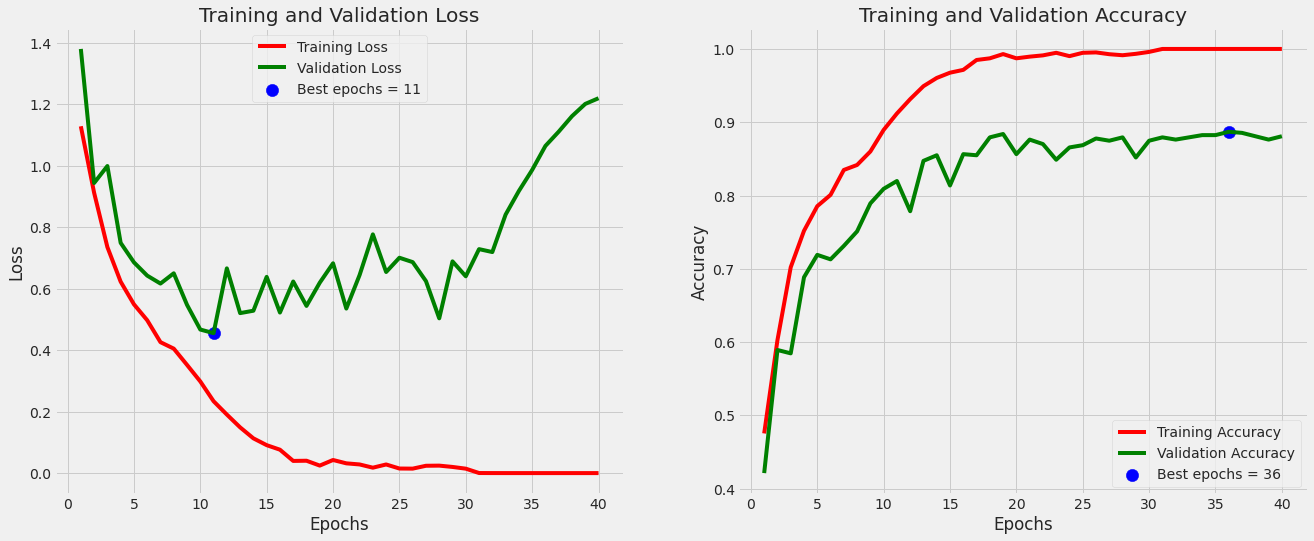

In [87]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.savefig('accuracy_loss.png')
plt.show();


In [71]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 1s 49ms/step - loss: 0.7880 - accuracy: 0.9258
Train Loss:  5.4016680905988324e-08
Train Accuracy:  1.0
--------------------
Validation Loss:  1.2726778984069824
Validation Accuracy:  0.87109375
--------------------
Test Loss:  0.7880210280418396
Test Accuracy:  0.92578125


In [ ]:
16/16 [==============================] - 1s 45ms/step - loss: 0.0885 - accuracy: 0.9688
16/16 [==============================] - 1s 44ms/step - loss: 0.2744 - accuracy: 0.9180
16/16 [==============================] - 1s 44ms/step - loss: 0.2111 - accuracy: 0.9102
Train Loss:  0.08853039145469666
Train Accuracy:  0.96875
--------------------
Validation Loss:  0.27439460158348083
Validation Accuracy:  0.91796875
--------------------
Test Loss:  0.21112148463726044
Test Accuracy:  0.91015625

In [72]:
preds = model.predict(test_gen)

y_pred = np.argmax(preds , axis = 1)

41/41 [==============================] - 2s 47ms/step


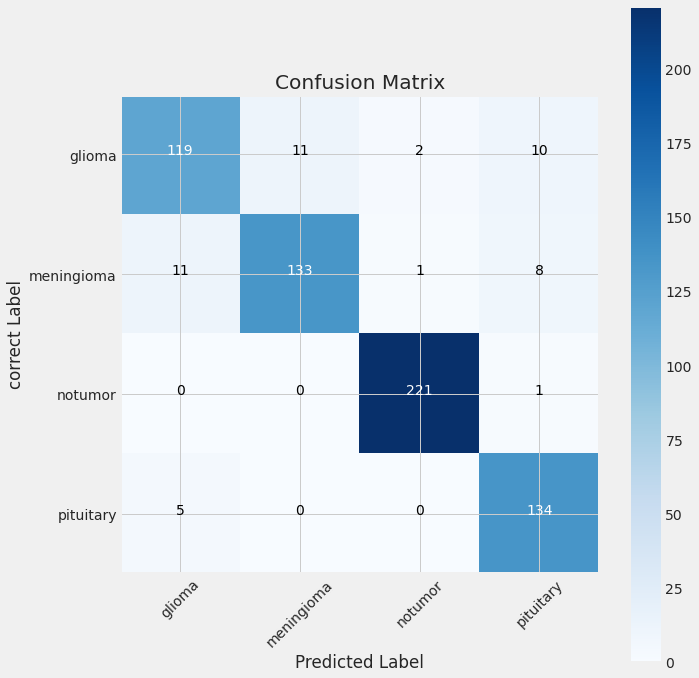

In [88]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('correct Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
plt.show()


In [74]:
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      glioma       0.88      0.84      0.86       142
  meningioma       0.92      0.87      0.90       153
     notumor       0.99      1.00      0.99       222
   pituitary       0.88      0.96      0.92       139

    accuracy                           0.93       656
   macro avg       0.92      0.92      0.92       656
weighted avg       0.93      0.93      0.92       656

